## Making sure Metropolis-Hastings works

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [3]:
def energy(sequence, J):
    """
    Calculate the Hamiltonian of the sequence.
    Args:
        sequence (np.array): The current sequence of spins.
        J (np.array): Interaction matrix.
    Returns:
        float: The energy of the current sequence.
    """
    return -np.sum(J * np.outer(sequence, sequence))

def set_interaction_mat(size, prob=[0.5,0.5]):
    J = np.random.choice([0,1],(size,size),p=prob) # interaction matrix
    J = (J.T + J)/2
    return J

In [72]:
def propose_sequence(current_sequence, num_of_flips=1, prob=0.5):
    """
    Propose a new sequence by flipping a set number of spins.
    Args:
        current_sequence (np.array): The current sequence of spins.
        num_of_flips (int): Number of spins to flip.
    Returns:
        np.array: The proposed sequence of spins.
    """
    new_sequence = current_sequence.copy()
    flip_indices = np.random.choice(len(new_sequence), num_of_flips, replace=False)
    flip_decisions = np.random.uniform(0, 1, size=num_of_flips) < prob
    #new_sequence[flip_indices] = -new_sequence[flip_indices]
    new_sequence[flip_indices[flip_decisions]] *= -1
    return new_sequence
'''
def propose_sequence(x, num_of_flips, prob):
    """
    Function:
        Flip one of the spins in the sequence at random
    Args:
        x: sequence of spins 
    """
    # Determine the indices to consider for flipping
    indices = np.random.choice(len(x), num_of_flips)
    # Generate random numbers for each chosen index to decide if a flip should occur
    flip_decisions = np.random.uniform(0, 1, size=num_of_flips) < prob
    # Apply flips where decided
    x[indices[flip_decisions]] *= -1
    return x
'''
def identify_and_flip_clusters(current_sequence, J, T):
    """
    Identify clusters based on J and propose a new sequence by flipping one of these clusters.
    Args:
        current_sequence (np.array): The current sequence of spins.
        J (np.array): Interaction matrix providing lattice and neighborhood information.
        T (float): Temperature, influencing the probability of flipping a cluster.
    Returns:
        np.array: The proposed sequence of spins after possibly flipping a cluster.
    """
    new_sequence = current_sequence.copy()
    size = len(current_sequence)
    # Randomly choose a starting point for the cluster
    start_index = np.random.randint(size)
    cluster = [start_index]
    for i in cluster:
        for j in range(size):
            # If spins are interacting strongly and not yet in the cluster, add them
            if J[i, j] > 0 and j not in cluster and current_sequence[i] == current_sequence[j]:
                # Add to the cluster based on a probability related to the interaction strength and temperature
                if np.random.rand() < np.exp(J[i, j] / T):
                    cluster.append(j)
    
    # Flip the entire cluster with some probability (could be based on size, energy, etc.)
    if np.random.rand() < 0.5:  # Example probability, adjust as needed
        for i in cluster:
            new_sequence[i] = -new_sequence[i]
    
    return new_sequence

def metropolis_hastings(J, initial_sequences, num_iters, T=1.0, num_of_flips=1):
    """
    Perform the Metropolis-Hastings algorithm on multiple sequences.
    Args:
        J (np.array): Interaction matrix.
        initial_sequences (list of np.array): Initial sequences of spins.
        num_iterations (int): Number of iterations to perform.
        T (float): Temperature.
        num_of_flips (int): Number of spins to flip in each proposal.
    Returns:
        list of np.array: Final sequences after iterations.
    """
    current_sequences = initial_sequences.copy()
    prob = 1.0 - np.exp(-2.0 *1/T)
    log_sequences = np.zeros((len(current_sequences), num_iters))
    for n in range(num_iters):
        for i in range(len(current_sequences)):
            proposed_sequence = propose_sequence(current_sequences[i], num_of_flips, prob)
            current_energy = energy(current_sequences[i], J)
            proposed_energy = energy(proposed_sequence, J)
            energy_difference = proposed_energy - current_energy
            #if (np.exp(current_energy/T) - np.exp(proposed_energy/T)) < 0 and (np.exp((current_energy - proposed_energy)/T) < prob):
            #if np.exp(-(current_energy - proposed_energy) / T) < np.random.rand():
            #if energy_difference < 0 or np.random.rand() < np.exp(-energy_difference / T):
            #if (energy_difference < 0) and (np.exp(energy_difference / T) < np.random.rand()):
            if energy_difference < 0:
                current_sequences[i] = proposed_sequence
        log_sequences[:,n] = np.absolute(np.sum(np.array(current_sequences), axis=1)/len(current_sequences[0]))
    return current_sequences, log_sequences

# Example usage:
np.random.seed(42)  # For reproducibility

size = 200  # Size of each sequence
num_sequences = 400  # Number of sequences
J = set_interaction_mat(size) # Example interaction matrix, should be symmetric
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]

final_sequences, log_sequences = metropolis_hastings(J, initial_sequences, num_iters=1000, T=1.0, num_of_flips=5)

# Final_sequences contains the sequences after they have potentially reached their stable states


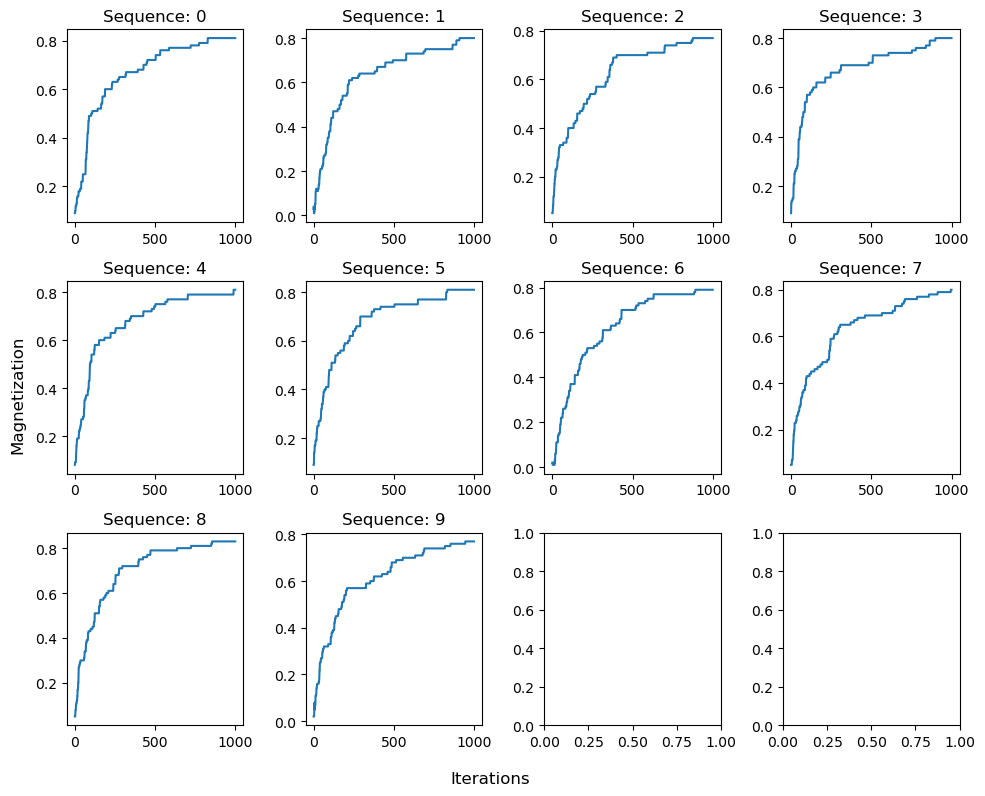

In [77]:
def plotting_magnetization(log_sequences):
    fig, ax = plt.subplots(3, 4, figsize=(10,8))
    k = 0
    for i in range(3):
        for j in range(4):
            ax[i,j].plot(np.arange(1000), log_sequences[k][:1000])
            ax[i,j].set_title("Sequence: "+str(k))
            k +=1
            if k == 10:
                break
    fig.supxlabel("Iterations")
    fig.supylabel("Magnetization")
    plt.tight_layout()
    plt.show()
plotting_magnetization(log_sequences)


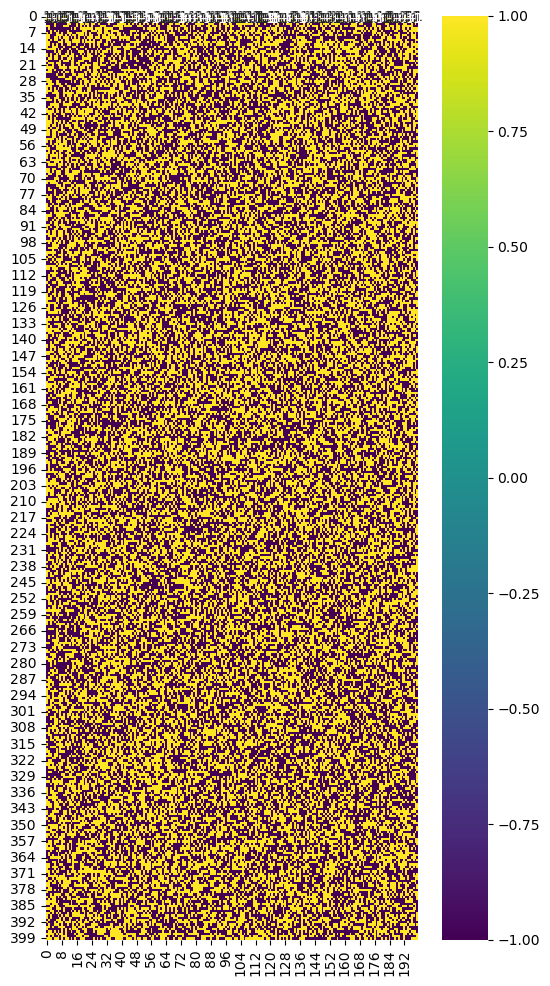

In [56]:
plt.figure(figsize=(6,12))
sns.heatmap(np.array(initial_sequences), cmap='viridis', annot=True)
plt.show()

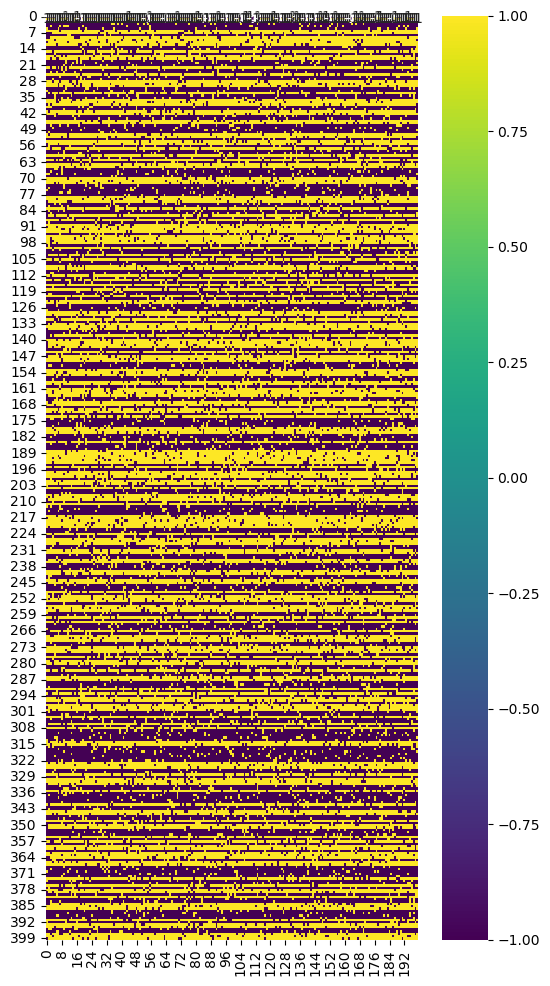

In [57]:
plt.figure(figsize=(6,12))
sns.heatmap(np.array(final_sequences), cmap='viridis', annot=True)
plt.show()

In [89]:
final_chains = np.array(final_sequences)
initial_chains = np.array(initial_sequences)
print("Number of chains:",final_chains.shape[0])
print("Number of spins in the chain:",final_chains.shape[1])

Number of chains: 400
Number of spins in the chain: 200


## Calculating TP fraction
1. Calculate covariance (or correlation matrix) (imported from the authors implementation)
2. Calculate frequencies

In [90]:
def ComputeCorrelationMatrix2(mat, pseudocount):
    
    nbr_spins = len(mat[0,:])
    nbr_chains = len(mat[:,0])
    mat = np.array(mat,ndmin = 2, dtype = np.float64)
    average_spin = np.average(mat, axis = 0)[:,None]
    
    directcorr = np.dot(mat.T, mat)
    
    directcorr *= np.true_divide(1, nbr_chains, dtype = np.float64)
    
    correlation_matrix = np.dot(1.0-pseudocount, directcorr) - np.dot(pow(1-pseudocount,2),np.outer(average_spin.T, average_spin)) + np.dot(pseudocount,np.identity(nbr_spins))
    
    return correlation_matrix

corr_mat = ComputeCorrelationMatrix2(final_chains, 0.5)
corr_mat

array([[0.9975    , 0.31925   , 0.3255    , ..., 0.289     , 0.29425   ,
        0.342625  ],
       [0.31925   , 0.999775  , 0.34515   , ..., 0.3047    , 0.299775  ,
        0.3425375 ],
       [0.3255    , 0.34515   , 0.9999    , ..., 0.3202    , 0.30515   ,
        0.362475  ],
       ...,
       [0.289     , 0.3047    , 0.3202    , ..., 0.9996    , 0.3047    ,
        0.33255   ],
       [0.29425   , 0.299775  , 0.30515   , ..., 0.3047    , 0.999775  ,
        0.3275375 ],
       [0.342625  , 0.3425375 , 0.362475  , ..., 0.33255   , 0.3275375 ,
        0.99999375]])

In [91]:
mat = final_chains
np.sum(mat[:,0] == 1)

180

In [94]:
def calc_frequency(mat,pseudocount):
    f = np.zeros((mat.shape[1]))
    for i in range(len(f)):
        f[i] = (1-pseudocount)*np.sum(mat[:,i] == 1)/mat.shape[0] + pseudocount/2
    return f

def coupled_frequency(mat,pseudocount):
    f_coupled = np.zeros((mat.shape[1], mat.shape[1]))
    for i in range(mat.shape[1]):
        for j in range(i+1, mat.shape[1]):
            one_to_one = 0
            for k in range(mat.shape[0]):
                # both are have 1 and 1 spins
                if mat[k,i] == mat[k,j]:
                    one_to_one += 1
            f_coupled[i,j] = (1-pseudocount)*one_to_one/mat.shape[0] + pseudocount/4
    return f_coupled
            
print("Individual frequency for occurence of 1:",calc_frequency(final_chains, 0.5))
print("Coupled frequency:",coupled_frequency(initial_chains, 0.5)[0])

Individual frequency for occurence of 1: [0.475   0.4925  0.505   0.4875  0.47875 0.48875 0.48625 0.49375 0.49375
 0.48875 0.49875 0.5     0.50125 0.485   0.485   0.49625 0.48375 0.4775
 0.4925  0.5     0.48375 0.48875 0.51    0.505   0.48875 0.5     0.49
 0.48375 0.49    0.495   0.4975  0.4925  0.48375 0.49875 0.48875 0.48625
 0.4925  0.49125 0.50875 0.49625 0.5     0.4875  0.5     0.4875  0.49
 0.4925  0.4825  0.49    0.495   0.48375 0.4875  0.48625 0.49    0.48375
 0.4875  0.49375 0.4875  0.49875 0.50125 0.4925  0.495   0.50125 0.49875
 0.49625 0.48875 0.48625 0.48625 0.50625 0.4925  0.5075  0.49625 0.49375
 0.48375 0.48375 0.49375 0.49125 0.50625 0.49125 0.4825  0.49375 0.5025
 0.49    0.48375 0.4975  0.485   0.49625 0.50875 0.48    0.49625 0.4925
 0.4925  0.5025  0.4875  0.4975  0.49125 0.495   0.4925  0.51625 0.4925
 0.4825  0.48625 0.4975  0.495   0.5025  0.5     0.5     0.49125 0.49375
 0.49125 0.48125 0.49125 0.49125 0.49375 0.48375 0.49    0.49625 0.48625
 0.4875  0.485   0.4

In [95]:
def MI(f_coupled, f_ind):
    MI_calc = 0
    for i in range(mat.shape[1]):
        for j in range(i+1, mat.shape[1]):
            MI_calc += f_coupled[i,j] * np.log(f_coupled[i,j]/(f_ind[i]*f_ind[j]))
    return MI_calc

MI(coupled_frequency(initial_chains, 0.5), calc_frequency(final_chains, 0.5))

3241.968805858876